In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from sklearn.metrics import auc

In [2]:
def load_df(file):
    '''
    Loads metadata tsv as df.
    '''
    with open(file) as tfile:
        df = pd.read_csv(tfile, sep = '\t')
        if 'nwgc_id' in df.columns:
            df['nwgc_id'] = df.nwgc_id.astype('str')
    return df

In [3]:
variants = load_df('../results/replicates/variant_frequencies.tsv')

In [4]:
variants

,id1,id2,replicate_no,freq1,freq2,snv,coverage1,coverage2,reads1,reads2,avg_ct
0,20200229_fastq_385186,20200302_fastq_385186,1,1.000000,0.999554,C5784T,143,118902,143.0,118849.0,22.411000
1,20200229_fastq_385186,20200302_fastq_385186,1,1.000000,0.999726,C8782T,151,124234,151.0,124200.0,22.411000
2,20200229_fastq_385186,20200302_fastq_385186,1,0.090909,0.061177,C9502T,143,149158,13.0,9125.0,22.411000
3,20200229_fastq_385186,20200302_fastq_385186,1,0.995192,0.997267,C17747T,208,167943,207.0,167484.0,22.411000
4,20200229_fastq_385186,20200302_fastq_385186,1,0.996078,0.998280,A17858G,255,164562,254.0,164279.0,22.411000
...,...,...,...,...,...,...,...,...,...,...,...
8096,20210115_fastq_501492,20210115_fastq_502599,77,0.000000,0.010407,T5952C,3230,3363,0.0,35.0,18.686825
8097,20210115_fastq_501492,20210115_fastq_502599,77,0.000000,0.010686,T13857C,3197,3556,0.0,38.0,18.686825
8098,20210115_fastq_501492,20210115_fastq_502599,77,0.000000,0.011195,T18552C,3202,3305,0.0,37.0,18.686825
8099,20210115_fastq_501492,20210115_fastq_502599,77,0.000000,0.010027,G19406A,3342,3690,0.0,37.0,18.686825


In [5]:
exclude = [1,2,3,4,5,6,7,8,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,53,54]

In [6]:
variants = variants[~variants.replicate_no.isin(exclude)]

In [7]:
variants.replicate_no.unique()

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77])

In [8]:
def plot_histograms(df, output):
    '''
    Plots density histogram of snvs by Ct, coverage, frequency, # of reads.
    Colors by intersection snv vs. not.
    '''
    df = df[(df.coverage1 >= 100) & (df.coverage2 >= 100)].copy()
    intersect = []
    for freq1, freq2 in zip(df.freq1, df.freq2):
        if freq1 and freq2 > 0:
            intersect.append('yes')
        else:
            intersect.append('no')
    df['intersect'] = intersect
    df['lowest_cov'] = df[['coverage1','coverage2']].min(axis=1)
    df['max_freq'] = df[['freq1', 'freq2']].max(axis=1)
    df['max_reads'] = df[['reads1', 'reads2']].max(axis=1)

    #df = df[(df.max_freq > 0.03) & (df.max_reads > 10) & (df.avg_ct < 28)].copy()

    
    part1 = df[['intersect', 'reads1', 'freq1']].rename(columns={'reads1':'reads', 'freq1':'freq'})
    part2 = df[['intersect', 'reads2', 'freq2']].rename(columns={'reads2':'reads', 'freq2':'freq'})
    merged = part1.append(part2)
    merged = merged[(merged.freq) > 0]

    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
    
    sns.histplot(df, x='avg_ct', hue='intersect', stat='count', element='step', ax=ax1, discrete=False, binwidth=1)
    ax1.set(ylabel='# of SNVs', xlabel='Average Ct')
    
    sns.histplot(merged, x='freq', hue='intersect', stat='count', element='step', ax=ax2, discrete=False, binwidth=0.005)
    ax2.set(ylabel='# of SNVs', xlabel='Frequency')  
    ax2z = plt.axes([0.65, 0.65, .18, .18])
    sns.histplot(merged, x='freq', hue='intersect', stat='count', element='step', ax=ax2z, discrete=False, legend=False, binwidth=0.005)
    ax2z.set_title('zoom')
    ax2z.set_xlim([0.005,0.1])
    ax2z.set_ylim([0,1000])
    #ax2z.set_yscale('log')
        
    sns.histplot(df, x='lowest_cov', hue='intersect', stat='count', element='step', ax=ax3, discrete=False, binwidth=25)
    ax3.set(ylabel='# of SNVs', xlabel='Coverage')
    ax3z = plt.axes([0.21, 0.23, .18, .18])
    sns.histplot(df, x='lowest_cov', hue='intersect', stat='count', element='step', ax=ax3z, discrete=False, legend=False, binwidth=25)
    ax3z.set_title('zoom')
    ax3z.set_xlim([0,4500])
    #ax3z.set_yscale('log')
    
    sns.histplot(merged, x='reads', hue='intersect', stat='count', element='step', ax=ax4, discrete=False, binwidth=5)
    ax4.set(ylabel='# of SNVs', xlabel='# of reads supporting SNV')
    ax4z = plt.axes([0.65, 0.23, .18, .18])
    sns.histplot(merged, x='reads', hue='intersect', stat='count', element='step', ax=ax4z, discrete=False, legend=False, binwidth=5)
    ax4z.set_title('zoom')
    ax4z.set_xlim([0,100])
    #ax4z.set_yscale('log')
    
    
    

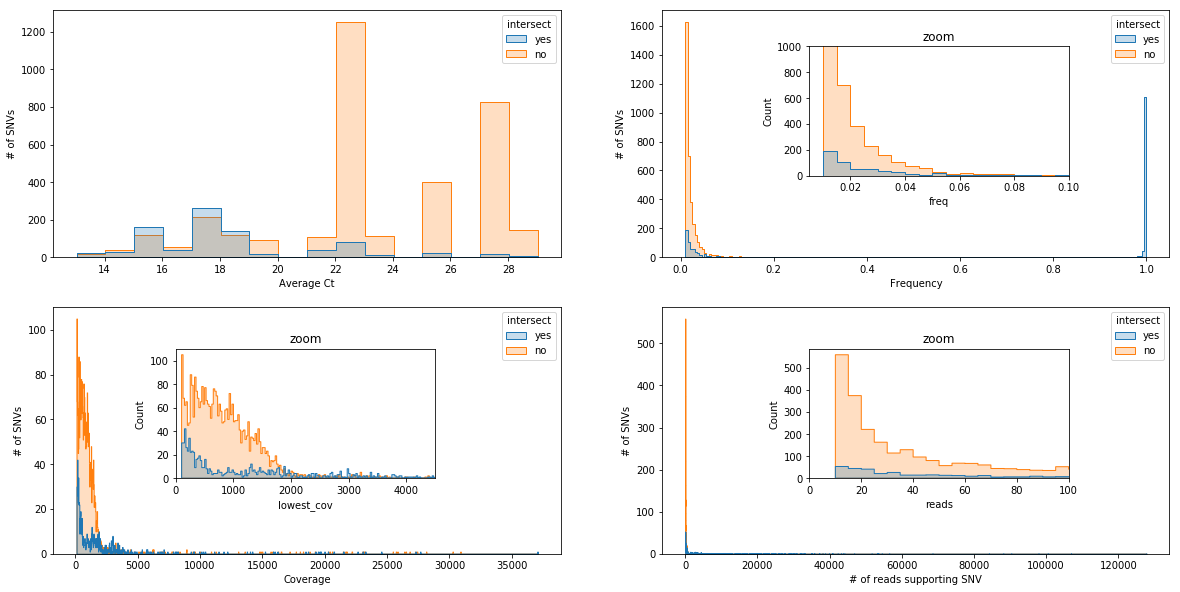

In [9]:
plot_histograms(variants, 'whatevs')

In [10]:
df = variants[(variants.coverage1 >= 100) & (variants.coverage2 >= 100)].copy()
df['max_freq'] = df[['freq1', 'freq2']].max(axis=1)

df = df[df.max_freq > 0.04].copy()
intersect = []
for freq1, freq2 in zip(df.freq1, df.freq2):
    if freq1 and freq2 > 0:
        intersect.append('yes')
    else:
        intersect.append('no')
df['intersect'] = intersect
df['lowest_cov'] = df[['coverage1','coverage2']].min(axis=1)
ct = [float(t[1:-1]) for t in df.avg_ct]
df['avg_ct'] = ct

part1 = df[['intersect', 'reads1', 'freq1', 'avg_ct']].rename(columns={'reads1':'reads', 'freq1':'freq'})
part2 = df[['intersect', 'reads2', 'freq2', 'avg_ct']].rename(columns={'reads2':'reads', 'freq2':'freq'})
merged = part1.append(part2)
merged = merged[merged.freq>0]

ax = sns.jointplot(data=merged, x='reads', y = 'freq', hue='intersect')
#ax.set_xlim([20,30])
#ax.set_ylim(0,2000)
#ax1.set(ylabel='# of SNVs', xlabel='Average Ct')



TypeError: 'float' object is not subscriptable

# Specificity & sensitivity of threshholds

In [11]:
def clean_variants(df):
    df = df[(df.coverage1 >= 100) & (df.coverage2 >= 100)].copy()
    intersect = []
    for freq1, freq2 in zip(df.freq1, df.freq2):
        if freq1 and freq2 > 0:
            intersect.append('yes')
        else:
            intersect.append('no')
    df['intersect'] = intersect
    df['lowest_cov'] = df[['coverage1','coverage2']].min(axis=1)
    df['max_freq'] = df[['freq1', 'freq2']].max(axis=1)
    df['max_reads'] = df[['reads1', 'reads2']].max(axis=1)
    #df = df[(df.max_freq < 0.04)].copy()
    return df

cleaned = clean_variants(variants)

In [12]:
def calc_sens_spec(df, var, thresh):
    '''
    Given variable and threshold, returns sensitivity & specificity for calling SNVs. 
    '''
    if var == 'avg_ct':
        below = df[df[var] > thresh]
        above = df[df[var] <= thresh]
    else:
        below = df[df[var] < thresh]
        above = df[df[var] >= thresh]
    tp = len(above[above.intersect == 'yes'])
    fp = len(above[above.intersect == 'no'])
    fn = len(below[below.intersect == 'yes'])
    tn = len(below[below.intersect == 'no'])
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    return sens, spec

In [13]:
def generate_sens_spec(df, var, threshold):
    '''
    Returns df containing sensitivity & specificity at each threshold for variable.
    '''
    sensitivity = []
    specificity = []
    variable = []
    for t in threshold:
        sens, spec = calc_sens_spec(df, var, t)
        sensitivity.append(sens)
        specificity.append(spec)
        variable.append(t)
    df = pd.DataFrame()
    df[var] = variable
    df['sensitivity'] = sensitivity
    df['specificity'] = specificity
    df['fpr'] = 1 - df['specificity']
    df['youden'] = df['sensitivity'] + df['specificity'] - 1
    return df
        

In [14]:
freq = np.arange(0.010, 0.2025, 0.0025)
ct = np.arange(10, 28.4, 0.1)
reads = np.arange(10, 40002, 2)
cov = np.arange(100, 5010, 10)
ct_cleaned = cleaned.dropna(subset = ['avg_ct'])

In [15]:
freq_df = generate_sens_spec(cleaned, 'max_freq', freq)
ct_df = generate_sens_spec(ct_cleaned, 'avg_ct', ct)
reads_df = generate_sens_spec(cleaned, 'max_reads', reads)
cov_df = generate_sens_spec(cleaned, 'lowest_cov', cov)

In [16]:
def plot_sens_spec(ct_df, freq_df, cov_df, reads_df):
    '''
    Plots sensitivity & specificity for variables.
    '''
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
    
    sns.lineplot(data=ct_df, x='avg_ct', y='sensitivity', ax=ax1, label='sensitivity', linewidth=2)
    ax1b=ax1.twinx()
    sns.lineplot(data=ct_df, x='avg_ct', y='specificity', color='red', ax=ax1b, label='specificity', linewidth=2)
    ax1.set(xlabel='Average Ct')
    ax1.set_ylim([0,1])
    ax1b.set_ylim([0,1])
    ax1.invert_xaxis()
    ax1b.legend(loc='center', bbox_to_anchor=(2.4, 0))
    ax1.legend(loc='center', bbox_to_anchor=(2.4, -0.1))
    ax1.grid(linestyle='dashed')
    ax1.set_xlim([max(ct_df['avg_ct']), 20])
    
    sns.lineplot(data=freq_df, x='max_freq', y='sensitivity', ax=ax2, linewidth=2)
    ax2b=ax2.twinx()
    sns.lineplot(data=freq_df, x='max_freq', y='specificity', color='red', ax=ax2b, linewidth=2)
    ax2.set(xlabel='Frequency')
    ax2.set_ylim([0,1])
    ax2b.set_ylim([0,1])
    ax2.grid(linestyle='dashed')
    ax2.set_xlim([0, 0.1])

    
    sns.lineplot(data=cov_df, x='lowest_cov', y='sensitivity', ax=ax3, linewidth=2)
    ax3b=ax3.twinx()
    sns.lineplot(data=cov_df, x='lowest_cov', y='specificity', color='red', ax=ax3b, linewidth=2)
    ax3.set(xlabel='Coverage')
    ax3.set_ylim([0,1])
    ax3b.set_ylim([0,1])
    ax3.grid(linestyle='dashed')
    ax3.set_xlim([0, 1500])
    
    sns.lineplot(data=reads_df, x='max_reads', y='sensitivity', ax=ax4, linewidth=2)
    ax4b=ax4.twinx()
    sns.lineplot(data=reads_df, x='max_reads', y='specificity', color='red', ax=ax4b, linewidth=2)
    ax4.set(xlabel='Minimum reads per SNV')
    ax4.set_ylim([0,1])
    ax4b.set_ylim([0,1])
    ax4.grid(linestyle='dashed')
    ax4.set_xlim([0,200])



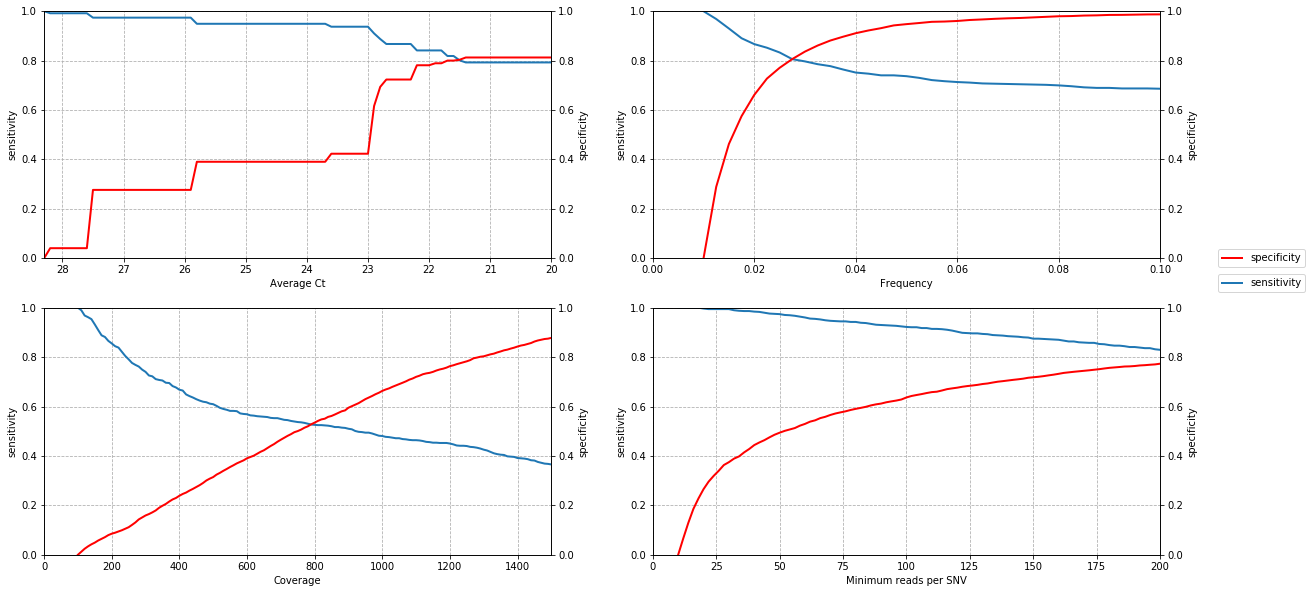

In [18]:
plot_sens_spec(ct_df, freq_df, cov_df, reads_df)

In [19]:
def plot_roc(freq_df, reads_df, cov_df, ct_df):
    '''
    Plots ROC curve
    '''
    youden_freq = freq_df['max_freq'][freq_df['youden'].idxmax()]
    youden_tpr = freq_df['sensitivity'][freq_df['youden'].idxmax()]
    youden_fpr = freq_df['fpr'][freq_df['youden'].idxmax()]
    mpl.rcParams.update({'font.size': 18})
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    
    
    for df, col, label in zip([freq_df, reads_df, cov_df, ct_df], ['#8338EC', '#3A86FF','#FF006E','#FFBE0B'], ['Frequency', 'Reads per SNV', 'Coverage', 'Average Ct']):
        AUC = "{:.2f}".format(auc(df['fpr'], df['sensitivity']))
        sns.lineplot(data=df, x='fpr', y='sensitivity', ax=ax1, color=col, label=(label + '; AUC=' + AUC), linewidth=2)
        ax1.set(ylabel='True positive rate = Sensitivity', xlabel = 'False positive rate = 1 - Specificity')
    ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
    ax1.grid(linestyle='dashed')
    ax1.legend()
    #ax1.vlines(x=youden_fpr, ymin=youden_fpr, ymax=youden_tpr, colors='black', linestyle='dotted')
    
    sns.lineplot(data=freq_df, x='max_freq', y='sensitivity', ax=ax2, linewidth=2, label='Sensitivity')
    ax2b=ax2.twinx()
    sns.lineplot(data=freq_df, x='max_freq', y='specificity', color='red', ax=ax2b, linewidth=2, label='Specificity')
    ax2.set(xlabel='Frequency', ylabel='Sensitivity')
    ax2b.set(ylabel='Specificity')
    ax2.set_ylim([0,1])
    ax2b.set_ylim([0,1])
    ax2.grid(linestyle='dashed')
    ax2.set_xlim([0, 0.1])
    ax2.axvline(x=youden_freq, c='black', ls='--')
    ax2b.legend(loc='center', bbox_to_anchor=(0.8, 0.8))
    ax2.legend(loc='center', bbox_to_anchor=(0.8, 0.7))
    ax2.text(x=0.0375, y=0.1, s='Maximum Youden Index:', fontsize=18, fontweight='bold')
    ax2.text(x=0.063, y=0.045, s='Freq={:.3f}'.format(youden_freq), fontsize=18, fontweight='bold')
    
    return plt.show()





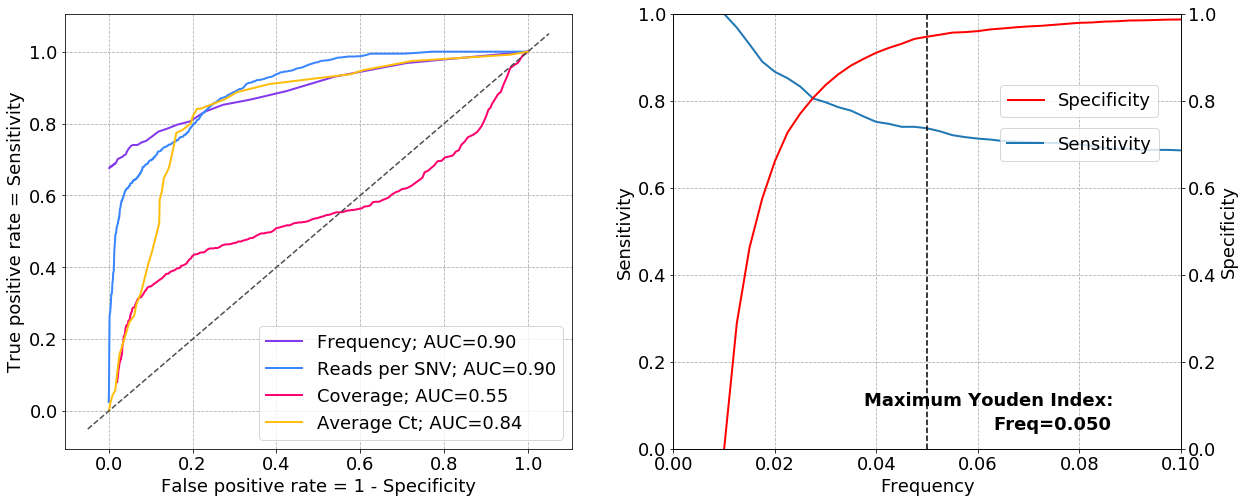

In [20]:
plot_roc(freq_df, reads_df, cov_df, ct_df)

In [21]:
def get_youden(freq_df, reads_df, ct_df, cov_df):
    youden_freq = freq_df['max_freq'][freq_df['youden'].idxmax()]
    youden_reads = reads_df['max_reads'][reads_df['youden'].idxmax()]
    youden_cov = cov_df['lowest_cov'][cov_df['youden'].idxmax()]
    youden_ct = ct_df['avg_ct'][ct_df['youden'].idxmax()]
    
    print('Youden Index cutoffs:')
    print('Frequency={:.3f}'.format(youden_freq))
    print('Reads=' + str(youden_reads))
    print('Coverage=' +str(youden_cov))
    print('Ct={:.2f}'.format(youden_ct))

get_youden(freq_df, reads_df, ct_df, cov_df)

Youden Index cutoffs:
Frequency=0.050
Reads=174
Coverage=1610
Ct=21.80


In [ ]:
youden_max